<a href="https://colab.research.google.com/github/Debrup-commits/Image-Segmentation-UNET/blob/main/Image_segmentation_UNET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Setup**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!cp /content/drive/MyDrive/NN\ Tasks/Semantic\ Segmentation\ UNET/train.zip /content/
!cp /content/drive/MyDrive/NN\ Tasks/Semantic\ Segmentation\ UNET/train_masks.zip /content/


In [ ]:
!unzip -q /content/train.zip
!unzip -q /content/train_masks.zip

In [ ]:
# to check if any missing masks as training mask and image folders have unequal size
import os
from os import listdir
 
# get the path/directory
folder_dir = "/content/train"
count=0

# iterating through train
for images in os.listdir(folder_dir):

    # getting mask path for each train image
    path= os.path.join('/content/train_masks/', images[:-4]+'_mask.gif')
    
    if os.path.isfile(path)==False:
      count+=1
      print("{} Mask(s) absent".format(count))



In [ ]:
#generating val and val_masks folders
import os
import shutil



val_path='/content/val'
val_mask_path='/content/val_masks'

# if above paths dont exist, make them
if os.path.isdir(val_path)==False:
  os.mkdir(val_path)
  os.mkdir(val_mask_path)

train = '/content/train'
train_mask = '/content/train_masks'

# take first 48 imgs and masks and make a small validation dataset to judge accuracy
i=1
for images in os.listdir(train):
  if i<49:
    image_path = os.path.join('/content/train/', images)
    image_mask_path = os.path.join('/content/train_masks/', images[:-4]+'_mask.gif')

    target_image_path = os.path.join('/content/val/', images)
    target_mask_path = os.path.join('/content/val_masks/', images[:-4]+'_mask.gif')

    # copy images into the new paths formed
    shutil.copyfile(image_path, target_image_path)
    shutil.copyfile(image_mask_path, target_mask_path)

  else:
    break
  
  i+=1

# **Dataset**

In [ ]:
import os
from PIL import Image
from torch.utils.data import Dataset
import numpy as np

class CarvanaDataset(Dataset):
  def __init__(self, img_dir, mask_dir, transform=None):
    self.img_dir=img_dir
    self.mask_dir=mask_dir
    self.transform=transform
    self.images=os.listdir(img_dir)
  
  def __len__(self):
    return len(self.images)

  def __getitem__(self, index):
      img_path=os.path.join(self.img_dir, self.images[index])
      mask_path=os.path.join(self.mask_dir, self.images[index].replace(".jpg", "_mask.gif"))

      image=np.array(Image.open(img_path).convert("RGB")) #img converted to RGB np array
      mask=np.array(Image.open(mask_path).convert("L"), dtype=np.float32) #mask converted to BnW np array

      #normalizing the mask for smaller calculations while training
      mask[mask==255.0]=1.0

      if self.transform is not None:
        transformations=self.transform(image=image, mask=mask)
        image=transformations["image"]
        mask=transformations["mask"]

      return image, mask

# **Our** **Model**

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as f

# making the UNET structure
class DoubleConv(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(DoubleConv, self).__init__()
    self.conv = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )

  def forward(self, x):
    return self.conv(x)

class UNET(nn.Module):
  def __init__(self, in_channels=3, out_channels=1, features=[64, 128, 256, 512]):
    super(UNET, self).__init__()
    self.downs=nn.ModuleList()
    self.ups=nn.ModuleList()
    self.pool=nn.MaxPool2d(kernel_size=2, stride=2)

    # Down part of UNET
    for feature in features:
      self.downs.append(DoubleConv(in_channels, feature))
      in_channels=feature

    for feature in reversed(features):
      self.ups.append(nn.ConvTranspose2d(2*feature, feature, kernel_size=2, stride=2))
      self.ups.append(DoubleConv(2*feature, feature))

    self.bottle_neck=DoubleConv(features[-1], 2*features[-1])

    self.final_conv=nn.Conv2d(features[0], out_channels, kernel_size=1)

  def forward(self, x):
    skip_connections=[]

    for down in self.downs:
      x=down(x)
      skip_connections.append(x)
      x=self.pool(x)

    x=self.bottle_neck(x)
    skip_connections=skip_connections[::-1]

    for idx in range(0, len(self.ups), 2):
      x=self.ups[idx](x)
      skip_connection=skip_connections[idx//2]

      if x.shape != skip_connection.shape:
        x = f.resize(x, size=skip_connection.shape[2:])

      concatenated_output=torch.cat((skip_connection, x), dim=1)
      x=self.ups[idx+1](concatenated_output)

    x=self.final_conv(x)

    return x


def test():
  x=torch.randn((3, 1, 160, 160))
  model=UNET(in_channels=1, out_channels=1)
  preds=model(x)

  print(x.shape, preds.shape)

  assert preds.shape==x.shape

if __name__=='__main__':
  test()
    

torch.Size([3, 1, 160, 160]) torch.Size([3, 1, 160, 160])


# **Helper functions**

In [ ]:
import torch
import torchvision
from torch.utils.data import DataLoader

def save_checkpoint(state, filename="my_checkpoint.pth.tar"):
  print("Saving CheckPoint!")
  torch.save(state, filename)

def load_checkpoint(checkpoint, model):
  print("Loading CheckPoint!")
  model.load_state_dict(checkpoint["state_dict"])

def get_loaders(
    train_dir,
    train_maskdir,
    val_dir,
    val_maskdir,
    batch_size,
    train_transform,
    val_transform,
    num_workers=4,
    pin_memory=True,
):
    train_ds = CarvanaDataset(
        img_dir=train_dir,
        mask_dir=train_maskdir,
        transform=train_transform,
    )

    train_loader = DataLoader(
        train_ds,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=pin_memory,
        shuffle=True,
    )

    val_ds = CarvanaDataset(
        img_dir=val_dir,
        mask_dir=val_maskdir,
        transform=val_transform,
    )

    val_loader = DataLoader(
        val_ds,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=pin_memory,
        shuffle=False,
    )

    return train_loader, val_loader

def check_accuracy(loader, model, device="cuda"):
  num_correct=0
  num_pixels=0
  model.eval()

  with torch.no_grad():
    for x, y in loader:
      x=x.to(device)
      y=y.to(device).unsqueeze(1)

      preds=torch.sigmoid(model(x))
      preds=(preds>0.5).float()

      num_correct+=(preds==y).sum()
      num_pixels+=torch.numel(preds)

  print("Accuracy: {:.2f}".format(num_correct/num_pixels*100))
  model.train()

def save_predictions_as_imgs(loader, model, folder='/content/segmented_masks', device="cuda"):
  model.eval()
  for idx, (x, y) in enumerate(loader):
    x=x.to(device)

    with torch.no_grad():

      preds=torch.sigmoid(model(x))
      preds=(preds>0.5).float()
    
    torchvision.utils.save_image(
        preds, f"{folder}/pred_{idx}.png"
    )
    torchvision.utils.save_image(y.unsqueeze(1), f"{folder}{idx}.png")

  model.train()


# **Training**

In [ ]:
! pip install albumentations==0.4.6

In [ ]:
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim

#HyperParameters
learning_rate=1e-4
device="cuda" if torch.cuda.is_available() else "cpu"
batch_size=16
num_epochs=50
num_workers=2
image_height=160
image_width=240
pin_memory=True
load_model=False

train_img_path='/content/train'
train_mask_path='/content/train_masks'
val_img_path='/content/val'
val_mask_path='/content/val_masks'

def train(loader, model, optimizer, loss_fn, scaler):
  loop=tqdm(loader)

  for batch_idx, (data, targets) in enumerate(loop):
    data=data.to(device)
    targets = targets.float().unsqueeze(1).to(device=device)

    # forward
    with torch.cuda.amp.autocast(): 
      predictions=model(data)
      loss=loss_fn(predictions, targets)

    # backward
    optimizer.zero_grad()
    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()

    # update tqdm loop
    loop.set_postfix(loss=loss.item())



def main():
  train_transforms=A.Compose([
                              A.Resize(height=image_height, width=image_width),
                              A.Rotate(limit=35, p=1.0),
                              A.HorizontalFlip(p=0.5),
                              A.VerticalFlip(p=0.1),
                              A.Normalize(
                                  mean=[0.0, 0.0, 0.0],
                                  std=[1.0, 1.0, 1.0],
                                  max_pixel_value=255.0,
                              ),
                              ToTensorV2()
  ])

  val_transforms = A.Compose([
                              A.Resize(height=image_height, width=image_width),
                              A.Normalize(
                                  mean=[0.0, 0.0, 0.0],
                                  std=[1.0, 1.0, 1.0],
                                  max_pixel_value=255.0,
                              ),
                              ToTensorV2()                            
  ])

  model = UNET(in_channels=3, out_channels=1).to(device)

  # Binary cross entropy with logits loss
  loss_fn = nn.BCEWithLogitsLoss() 
  optimizer = optim.Adam(model.parameters(), lr=learning_rate)

  train_loader, val_loader = get_loaders(
      train_img_path,
      train_mask_path,
      val_img_path,
      val_mask_path,
      batch_size,
      train_transforms,
      val_transforms,
      num_workers,
      pin_memory
  )

  if load_model:
    load_checkpoint(torch.load("my_checkpoint.pth.tar"))

  scaler = torch.cuda.amp.GradScaler()

  for epoch in range(num_epochs):
    train(train_loader, model, optimizer, loss_fn, scaler)
    checkpoint = {
        "state_dict" : model.state_dict(),
        "optimizer" : optimizer.state_dict()
    }
    save_checkpoint(checkpoint)

    # check accuracy
    check_accuracy(val_loader, model, device=device)

    # save some predictions
    saved_img_path='/content/segmented_masks'
    if os.path.isdir(saved_img_path)==False:
      os.mkdir(saved_img_path)

    save_predictions_as_imgs(val_loader, model, folder=saved_img_path, device=device)


if __name__=='__main__':
  main()



100%|██████████| 318/318 [03:50<00:00,  1.38it/s, loss=0.119]


Saving CheckPoint!
Accuracy: 98.42100524902344:.2f


100%|██████████| 318/318 [03:50<00:00,  1.38it/s, loss=0.0749]


Saving CheckPoint!
Accuracy: 99.28792572021484:.2f


100%|██████████| 318/318 [03:51<00:00,  1.38it/s, loss=0.046]


Saving CheckPoint!
Accuracy: 99.29177856445312:.2f


100%|██████████| 318/318 [03:50<00:00,  1.38it/s, loss=0.0348]


Saving CheckPoint!
Accuracy: 99.42687225341797:.2f


100%|██████████| 318/318 [03:53<00:00,  1.36it/s, loss=0.0274]


Saving CheckPoint!
Accuracy: 99.42203521728516:.2f


100%|██████████| 318/318 [03:52<00:00,  1.37it/s, loss=0.0335]


Saving CheckPoint!
Accuracy: 94.78163146972656:.2f


100%|██████████| 318/318 [03:57<00:00,  1.34it/s, loss=0.0206]


Saving CheckPoint!
Accuracy: 99.40321350097656:.2f


100%|██████████| 318/318 [03:54<00:00,  1.35it/s, loss=0.0181]


Saving CheckPoint!
Accuracy: 99.55279541015625:.2f


100%|██████████| 318/318 [03:53<00:00,  1.36it/s, loss=0.0158]


Saving CheckPoint!
Accuracy: 99.55311584472656:.2f


100%|██████████| 318/318 [03:56<00:00,  1.35it/s, loss=0.0154]


Saving CheckPoint!
Accuracy: 99.58382415771484:.2f


100%|██████████| 318/318 [03:52<00:00,  1.37it/s, loss=0.0168]


Saving CheckPoint!
Accuracy: 99.58767700195312:.2f


100%|██████████| 318/318 [03:51<00:00,  1.37it/s, loss=0.0139]


Saving CheckPoint!
Accuracy: 99.57986450195312:.2f


100%|██████████| 318/318 [03:52<00:00,  1.37it/s, loss=0.0135]


Saving CheckPoint!
Accuracy: 99.61664581298828:.2f


100%|██████████| 318/318 [03:50<00:00,  1.38it/s, loss=0.0146]


Saving CheckPoint!
Accuracy: 99.62831115722656:.2f


100%|██████████| 318/318 [03:50<00:00,  1.38it/s, loss=0.0129]


Saving CheckPoint!
Accuracy: 99.62386322021484:.2f


100%|██████████| 318/318 [03:49<00:00,  1.39it/s, loss=0.013]


Saving CheckPoint!
Accuracy: 99.60514068603516:.2f


100%|██████████| 318/318 [03:49<00:00,  1.38it/s, loss=0.011]


Saving CheckPoint!
Accuracy: 99.63764190673828:.2f


100%|██████████| 318/318 [03:53<00:00,  1.36it/s, loss=0.0125]


Saving CheckPoint!
Accuracy: 99.62234497070312:.2f


100%|██████████| 318/318 [03:48<00:00,  1.39it/s, loss=0.0109]


Saving CheckPoint!
Accuracy: 99.60113525390625:.2f


100%|██████████| 318/318 [03:49<00:00,  1.38it/s, loss=0.0109]


Saving CheckPoint!
Accuracy: 99.64996337890625:.2f


100%|██████████| 318/318 [03:48<00:00,  1.39it/s, loss=0.00978]


Saving CheckPoint!
Accuracy: 99.6691665649414:.2f


100%|██████████| 318/318 [03:49<00:00,  1.38it/s, loss=0.011]


Saving CheckPoint!
Accuracy: 99.61783599853516:.2f


100%|██████████| 318/318 [03:56<00:00,  1.35it/s, loss=0.0103]


Saving CheckPoint!
Accuracy: 99.64627075195312:.2f


100%|██████████| 318/318 [03:48<00:00,  1.39it/s, loss=0.00937]


Saving CheckPoint!
Accuracy: 99.6637954711914:.2f


100%|██████████| 318/318 [03:52<00:00,  1.37it/s, loss=0.013]


Saving CheckPoint!
Accuracy: 99.6388931274414:.2f


100%|██████████| 318/318 [03:50<00:00,  1.38it/s, loss=0.00961]


Saving CheckPoint!
Accuracy: 99.67366790771484:.2f


100%|██████████| 318/318 [03:48<00:00,  1.39it/s, loss=0.00944]


Saving CheckPoint!
Accuracy: 99.68245697021484:.2f


100%|██████████| 318/318 [03:52<00:00,  1.37it/s, loss=0.01]


Saving CheckPoint!
Accuracy: 99.67996215820312:.2f


100%|██████████| 318/318 [03:54<00:00,  1.35it/s, loss=0.00903]


Saving CheckPoint!
Accuracy: 99.67317962646484:.2f


100%|██████████| 318/318 [03:53<00:00,  1.36it/s, loss=0.011]


Saving CheckPoint!
Accuracy: 99.24967956542969:.2f


100%|██████████| 318/318 [03:50<00:00,  1.38it/s, loss=0.00839]


Saving CheckPoint!
Accuracy: 99.66325378417969:.2f


100%|██████████| 318/318 [03:50<00:00,  1.38it/s, loss=0.0111]


Saving CheckPoint!
Accuracy: 99.5798110961914:.2f


100%|██████████| 318/318 [03:51<00:00,  1.37it/s, loss=0.0102]


Saving CheckPoint!
Accuracy: 99.65896606445312:.2f


100%|██████████| 318/318 [03:52<00:00,  1.37it/s, loss=0.0101]


Saving CheckPoint!
Accuracy: 99.67035675048828:.2f


100%|██████████| 318/318 [03:52<00:00,  1.37it/s, loss=0.00913]


Saving CheckPoint!
Accuracy: 99.68701934814453:.2f


100%|██████████| 318/318 [03:50<00:00,  1.38it/s, loss=0.00875]


Saving CheckPoint!
Accuracy: 99.69287872314453:.2f


100%|██████████| 318/318 [03:51<00:00,  1.37it/s, loss=0.00863]


Saving CheckPoint!
Accuracy: 99.69298553466797:.2f


100%|██████████| 318/318 [03:52<00:00,  1.37it/s, loss=0.00952]


Saving CheckPoint!
Accuracy: 99.69688415527344:.2f


100%|██████████| 318/318 [03:50<00:00,  1.38it/s, loss=0.00912]


Saving CheckPoint!
Accuracy: 99.68696594238281:.2f


100%|██████████| 318/318 [03:50<00:00,  1.38it/s, loss=0.00854]


Saving CheckPoint!
Accuracy: 99.69319915771484:.2f


100%|██████████| 318/318 [03:49<00:00,  1.39it/s, loss=0.00917]


Saving CheckPoint!
Accuracy: 99.630859375:.2f


100%|██████████| 318/318 [03:51<00:00,  1.37it/s, loss=0.00852]


Saving CheckPoint!
Accuracy: 99.66059112548828:.2f


100%|██████████| 318/318 [03:51<00:00,  1.37it/s, loss=0.00819]


Saving CheckPoint!
Accuracy: 99.67925262451172:.2f


100%|██████████| 318/318 [03:53<00:00,  1.36it/s, loss=0.00878]


Saving CheckPoint!
Accuracy: 99.69841003417969:.2f


100%|██████████| 318/318 [03:51<00:00,  1.37it/s, loss=0.00747]


Saving CheckPoint!
Accuracy: 99.70182800292969:.2f


100%|██████████| 318/318 [03:49<00:00,  1.38it/s, loss=0.00928]


Saving CheckPoint!
Accuracy: 99.697265625:.2f


100%|██████████| 318/318 [03:52<00:00,  1.37it/s, loss=0.00863]


Saving CheckPoint!
Accuracy: 99.7028579711914:.2f


 27%|██▋       | 87/318 [01:05<02:54,  1.32it/s, loss=0.00998]


KeyboardInterrupt: ignored

# **Testing**

In [ ]:
model=UNET()
load_checkpoint(torch.load('/content/drive/MyDrive/NN Tasks/Semantic Segmentation UNET/my_checkpoint.pth.tar'), model)

device="cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

Loading CheckPoint!


UNET(
  (downs): ModuleList(
    (0): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (1): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=T

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms as transforms

# read and resize image to input size
frame = cv2.imread('/content/drive/MyDrive/NN Tasks/Semantic Segmentation UNET/car.png')
frame=cv2.resize(frame, (240, 160))

# converting to tensor of batch 1
tensor=f.to_tensor(frame)
tensor=tensor.unsqueeze(0)
tensor=tensor.to(device)

# prediction
preds=torch.sigmoid(model(tensor))
preds=(preds>0.5).float()

# saving prediction
torchvision.utils.save_image(preds, f"check.png")
pred_img=cv2.imread('/content/check.png')


**Visualise**

Text(0.5, 1.0, 'Prediction')

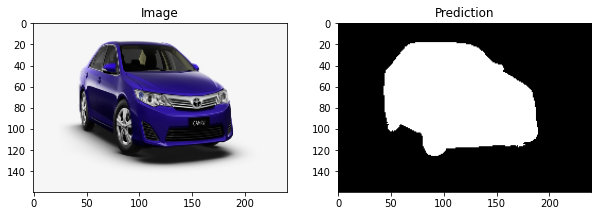

In [ ]:
fig = plt.figure(figsize=(10, 7))
  
# setting values to rows and column variables
rows = 1
columns = 2

# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 1)
  
# showing image
plt.imshow(frame)
plt.title("Image")
  
# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns, 2)
  
# showing image
plt.imshow(pred_img)
plt.title("Prediction")